In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import wandb
import Neural_Lib_Flo as nlb
import wandb_library as wl 
import training_lib as tl

In [3]:
# Set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Set the root directory
root_dir_sensorium = '/project/data/static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6/data'
images_path = '/project/subiculum/data/images_uint8.npy'
v1_responses_path = '/project/subiculum/data/V1_Data.mat'
sub_responses_path= '/project/subiculum/data/Post_Sub_Data.mat'

I have already run a sweep using wandb, so this won't be done again here.

In [4]:
api = wandb.Api()
run = api.run("seifertflo/V1 Training 17-06-2024/2mr3hewa")
config=run.config
v1_model=nlb.configure_model(config, 13, device)
v1_train_loader, v1_val_loader, v1_test_loader = nlb.dataloader_from_mat(images_path, v1_responses_path, 75, 125, 64)
tl.train_and_eval(v1_model, config.get("epochs"), v1_train_loader, v1_test_loader, v1_val_loader, device)

/usr/local/lib/python3.8/dist-packages/neuralpredictors/measures/modules.py:78: UserWarning: Poissonloss is averaged per batch. It's recommended to use `sum` instead
  warnings.warn("Poissonloss is averaged per batch. It's recommended to use `sum` instead")


Epoch [1/50], validation correlation: 0.0040, trainloss: 0.2787
Epoch [2/50], validation correlation: 0.0854, trainloss: 0.3136
Epoch [3/50], validation correlation: 0.0891, trainloss: 0.3109
Epoch [4/50], validation correlation: 0.0627, trainloss: 0.3028
Epoch [5/50], validation correlation: 0.0837, trainloss: 0.2611
Epoch [6/50], validation correlation: 0.0829, trainloss: 0.2664
Epoch     7: reducing learning rate of group 0 to 1.0000e-02.
Epoch [7/50], validation correlation: 0.0655, trainloss: 0.2976
Epoch [8/50], validation correlation: 0.0912, trainloss: 0.2841
Epoch [9/50], validation correlation: 0.1014, trainloss: 0.2561
Epoch [10/50], validation correlation: 0.1008, trainloss: 0.3945
Epoch [11/50], validation correlation: 0.1000, trainloss: 0.2230
Epoch [12/50], validation correlation: 0.0986, trainloss: 0.2382
Epoch    13: reducing learning rate of group 0 to 1.0000e-03.
Epoch [13/50], validation correlation: 0.1009, trainloss: 0.4103
Epoch [14/50], validation correlation: 0

We can now use the same configuration to get a rough idea of what training with the Sub Data would give:

In [5]:
sub_train_loader, sub_val_loader, sub_test_loader =nlb.dataloader_from_mat(images_path, sub_responses_path, 75, 125, 64)
sub_model=nlb.configure_model(config, 37, device)
tl.train_and_eval(sub_model, config.get("epochs"),sub_train_loader, sub_val_loader, sub_test_loader, device), 

Epoch [1/50], validation correlation: 0.0208, trainloss: 0.4569
Epoch [2/50], validation correlation: 0.0684, trainloss: 0.4276
Epoch [3/50], validation correlation: 0.0737, trainloss: 0.4043
Epoch [4/50], validation correlation: 0.0631, trainloss: 0.2720
Epoch [5/50], validation correlation: 0.0602, trainloss: 0.5383
Epoch [6/50], validation correlation: 0.0295, trainloss: 0.3151
Epoch     7: reducing learning rate of group 0 to 1.0000e-02.
Epoch [7/50], validation correlation: 0.0632, trainloss: 0.4333
Epoch [8/50], validation correlation: 0.0656, trainloss: 0.4333
Early stopping triggered!
Test Loss: 0.4366
Test Correlation: 0.0606


(None,)

As one gets a correlation of ~30% for the Sensorium data, it would be helpful to understand why this is not reached for the v1 data here. 

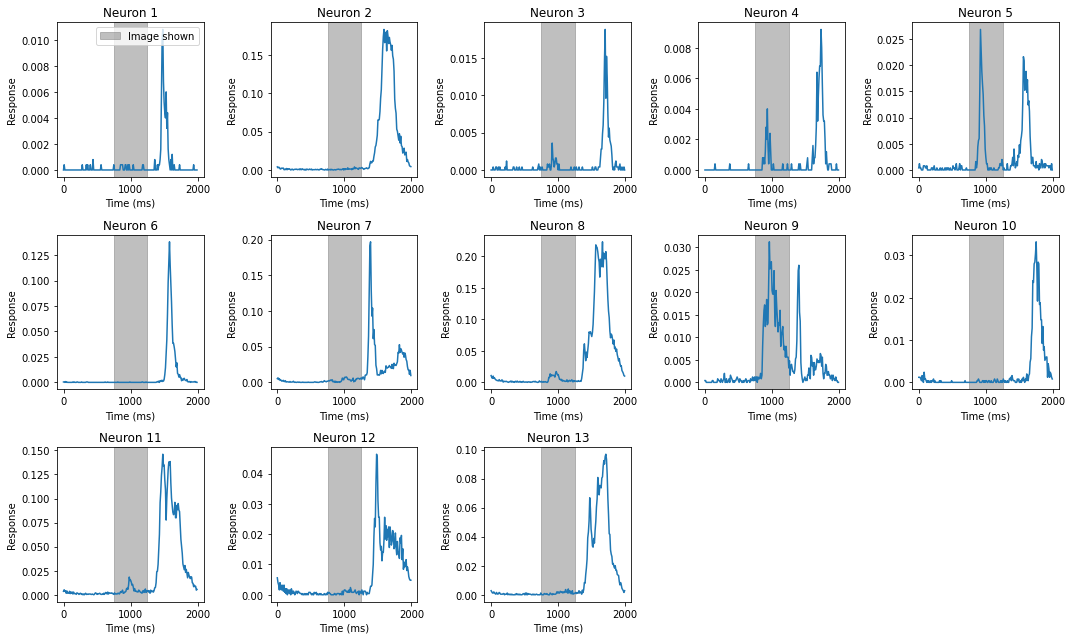

In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Load Images to np.array
images = np.load(images_path)

# Load responses and preprocess them
v1_responses, _, _ = nlb.load_mat_file(v1_responses_path)
v1_responses = np.transpose(v1_responses, (1, 2, 0))

# Look at mean data for neurons
v1_responses_mean = np.mean(v1_responses, axis=0, keepdims=True)

# Define the number of plots
num_plots = 13
neuron_indices = range(num_plots)

# Create a 3x5 grid of subplots
fig, axs = plt.subplots(3, 5, figsize=(15, 9))
axs = axs.flatten()  # Flatten the 2D array to 1D for easier iteration

# Create a custom legend patch
legend_patch = mpatches.Patch(color='gray', alpha=0.5, label='Image shown')

# Plot each neuron data
x = np.arange(0, 2000, 10)
for i, neuron_index in enumerate(neuron_indices):
    if i < len(neuron_indices):  # Ensure we don't go out of bounds
        neuron_mean = v1_responses_mean[:, :, neuron_index]
        axs[i].plot(x, neuron_mean[0, :])
        axs[i].axvspan(750, 1250, color='gray', alpha=0.5)  # Add transparent gray tile
        axs[i].set_title(f'Neuron {neuron_index + 1}')
        axs[i].set_xlabel('Time (ms)')
        axs[i].set_ylabel('Response')
        # Add the legend to the first plot only to avoid repetition
        if i == 0:
            axs[i].legend(handles=[legend_patch])

# Remove empty subplots (if any)
for j in range(len(neuron_indices), len(axs)):
    fig.delaxes(axs[j])

# Adjust layout
plt.tight_layout()
plt.show()

This shows the structure of the responses.
Now Ill compute oracle of the sensorium Data to compare the best neurons to the neurons here.

In [7]:
sensorium_train_loader, sensorium_val_loader, sensorium_test_loader = nlb.dataloader_from_npy_pretraining(root_dir_sensorium, device)
sensorium_model = nlb.ConvModel(layers=5, input_kern=11, hidden_kern=5, hidden_channels=32, output_dim=8372).to(device)
tl.train_and_eval(sensorium_model, 100, sensorium_train_loader, sensorium_test_loader, sensorium_val_loader, device,gamma=1e-2,lr=1e-3, save_model=True, path_for_saving=("models/sens_model.pt"))

/usr/local/lib/python3.8/dist-packages/neuralpredictors/measures/modules.py:78: UserWarning: Poissonloss is averaged per batch. It's recommended to use `sum` instead
  warnings.warn("Poissonloss is averaged per batch. It's recommended to use `sum` instead")


Epoch [1/100], validation correlation: 0.0502, trainloss: 0.8761
Epoch [2/100], validation correlation: 0.0569, trainloss: 0.7107
Epoch [3/100], validation correlation: 0.0668, trainloss: 0.6243
Epoch [4/100], validation correlation: 0.0675, trainloss: 0.5810
Epoch [5/100], validation correlation: 0.0761, trainloss: 0.5887
Epoch [6/100], validation correlation: 0.0789, trainloss: 0.5763
Epoch [7/100], validation correlation: 0.0799, trainloss: 0.6020
Epoch [8/100], validation correlation: 0.0847, trainloss: 0.5990
Epoch [9/100], validation correlation: 0.0862, trainloss: 0.6566
Epoch [10/100], validation correlation: 0.0891, trainloss: 0.5659
Epoch [11/100], validation correlation: 0.0937, trainloss: 0.5699
Epoch [12/100], validation correlation: 0.0976, trainloss: 0.6142
Epoch [13/100], validation correlation: 0.1014, trainloss: 0.4745
Epoch [14/100], validation correlation: 0.1004, trainloss: 0.5324
Epoch [15/100], validation correlation: 0.1110, trainloss: 0.5391
Epoch [16/100], val

In [9]:
state_dict_sens = torch.load('models/sens_model.pt')
sensorium_model.load_state_dict(state_dict_sens)
sensorium_model.to(device)

ConvModel(
  (conv_layers): Sequential()
  (core): Sequential(
    (0): Conv2d(1, 32, kernel_size=(11, 11), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU()
    (3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): SiLU()
    (6): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): SiLU()
    (9): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): SiLU()
    (12): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (13): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): SiLU()
  )
  (readout): GaussianReadou

In [10]:
with torch.no_grad():
    sens_val_corrs = nlb.get_correlations(sensorium_model, sensorium_val_loader, device)
best_neurons = np.argsort(-sens_val_corrs)

Now we will compute the spike triggered average (which can be seen as a first approximation of a MEI)
1. Do it by averaging over the images: implement a function for this. Advantage: Does not rely on the trained model.
2. Use the model: Here we can use random inputs to generate STAs.
3. Use the model: Compute Gradient RFs
4. Generate MEIs.

1630